The following code and resources are based on the previous work from these repositories:

* [Enod-Bataa's Repository 2022](https://github.com/enod-bataa/scaling-telegram.git)
* [DL UB Summer School 2023 Repository](https://github.com/dl-ub-summer-school/2023)

Credits go to Enod-Bataa and Iveel

#### Import libraries

In [ ]:
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from torch.optim import Adam
import collections
import random
import math
import numpy as np

In [ ]:
# Hyper parameters
gpu_id=0
seed=42
save=0

device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else 'cpu')
print("device", device)

num_enc_layers=6
num_dec_layers=6
max_len=20
model_dim=512
hidden_size=2048
d_k=64
d_v=64
n_head=8
d_prob=0.1
max_norm=5.0

# attention is all you need hyper-params
n_epochs=100
batch_size=128
lr=1e-3
beta1=0.9
beta2=0.98
eps=1e-9
weight_decay=1e-3
# bluescore
k=4

device cuda:0


# Implementing Transformer from scratch

![ alt Transformers](https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png)



---


- Objective: Implement Transformer architecture from scratch

- Approach: Down to Top

- Visuals credits goes to : https://www.youtube.com/watch?v=dichIcUZfOw&t=635s

## 1. Embeddings and Positional embedding

### 1.1 Input processing

First we create a dictionary for all the words we have with corresponding indexes. And this dictionary will be used as a lookup table for converting text into a series of numbers.

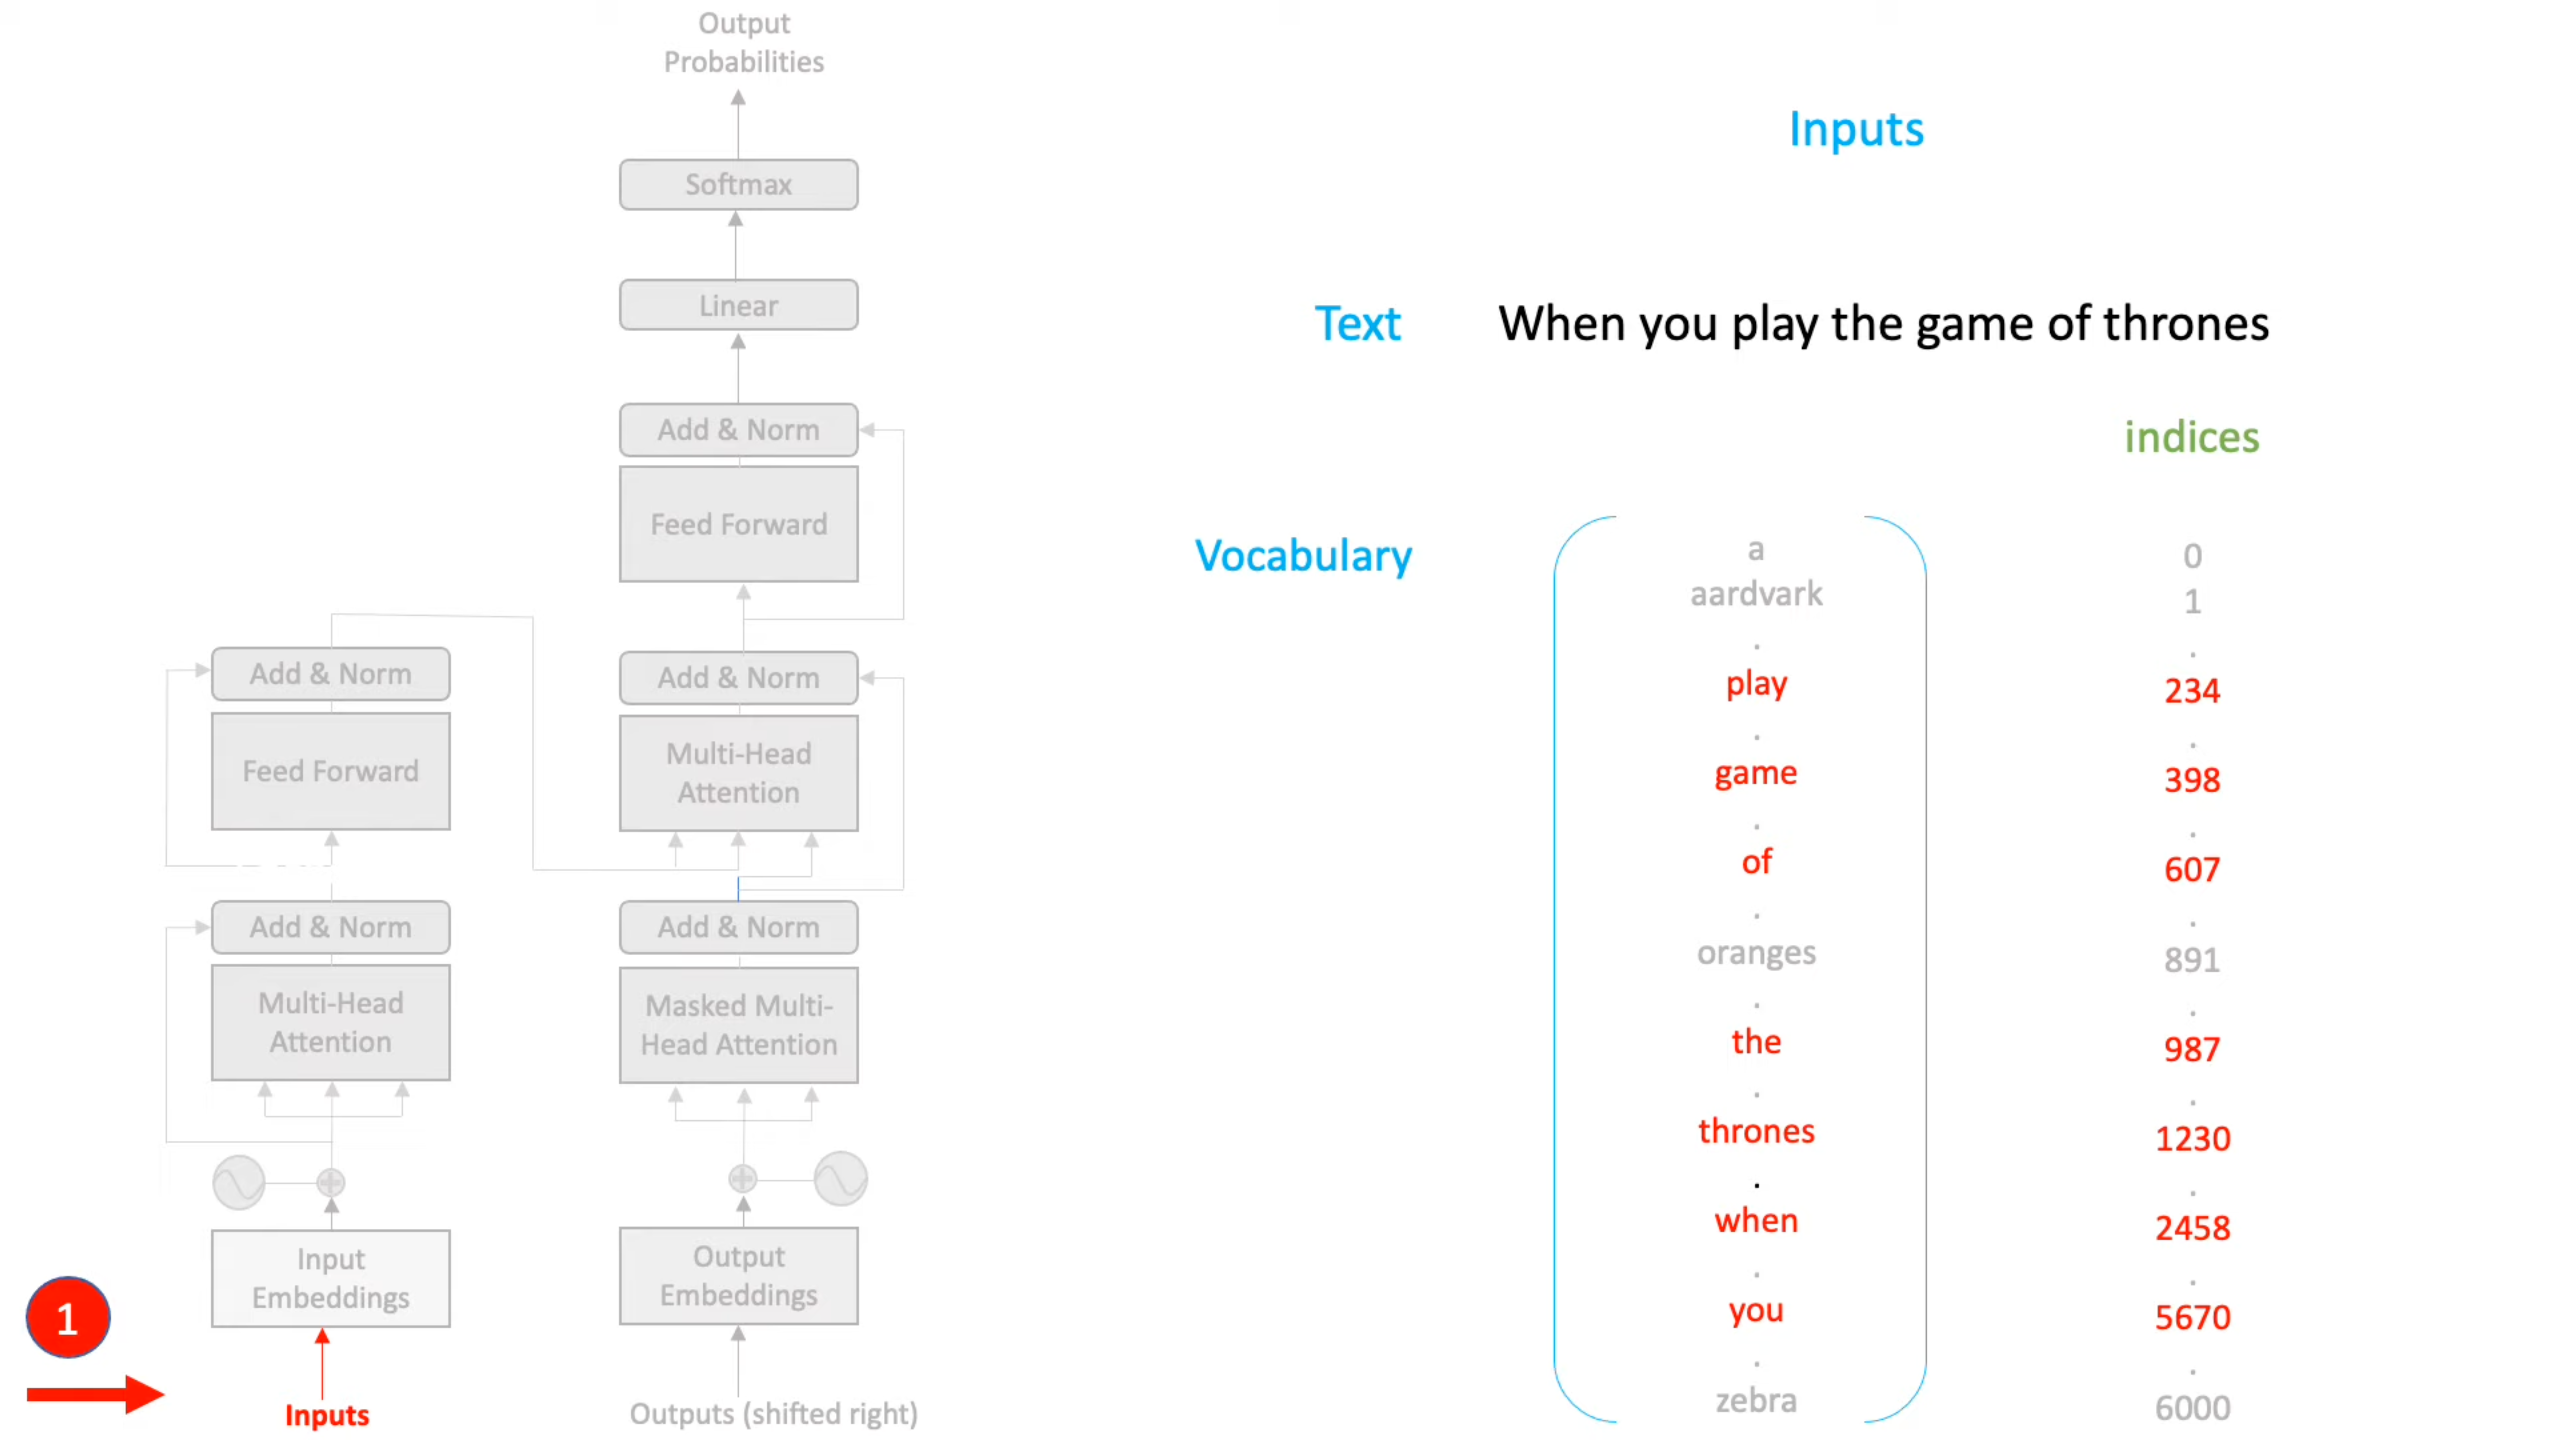

---



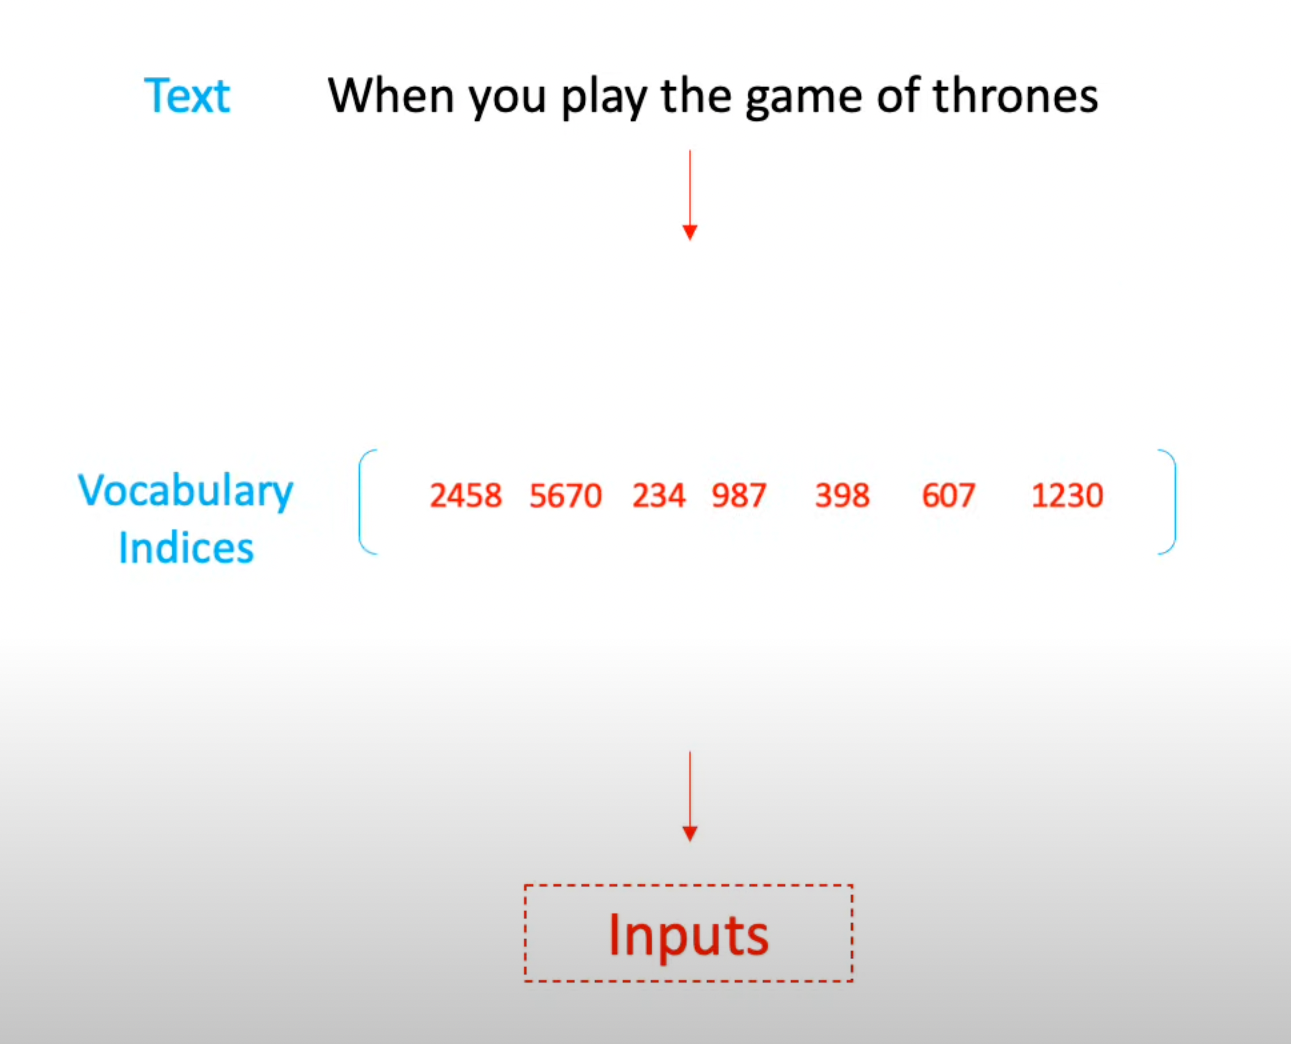

### 1.2 Embedding layer

Once we are done with above, then we need to pass the numeric representation into an embedding layer. But what is an embedding? Embedding is simply a vector representation of words. It is first initialised with random number and during the training process, it will be learnt so that similar words in the context will be close in the vector space - hence understands the meanining at some level.

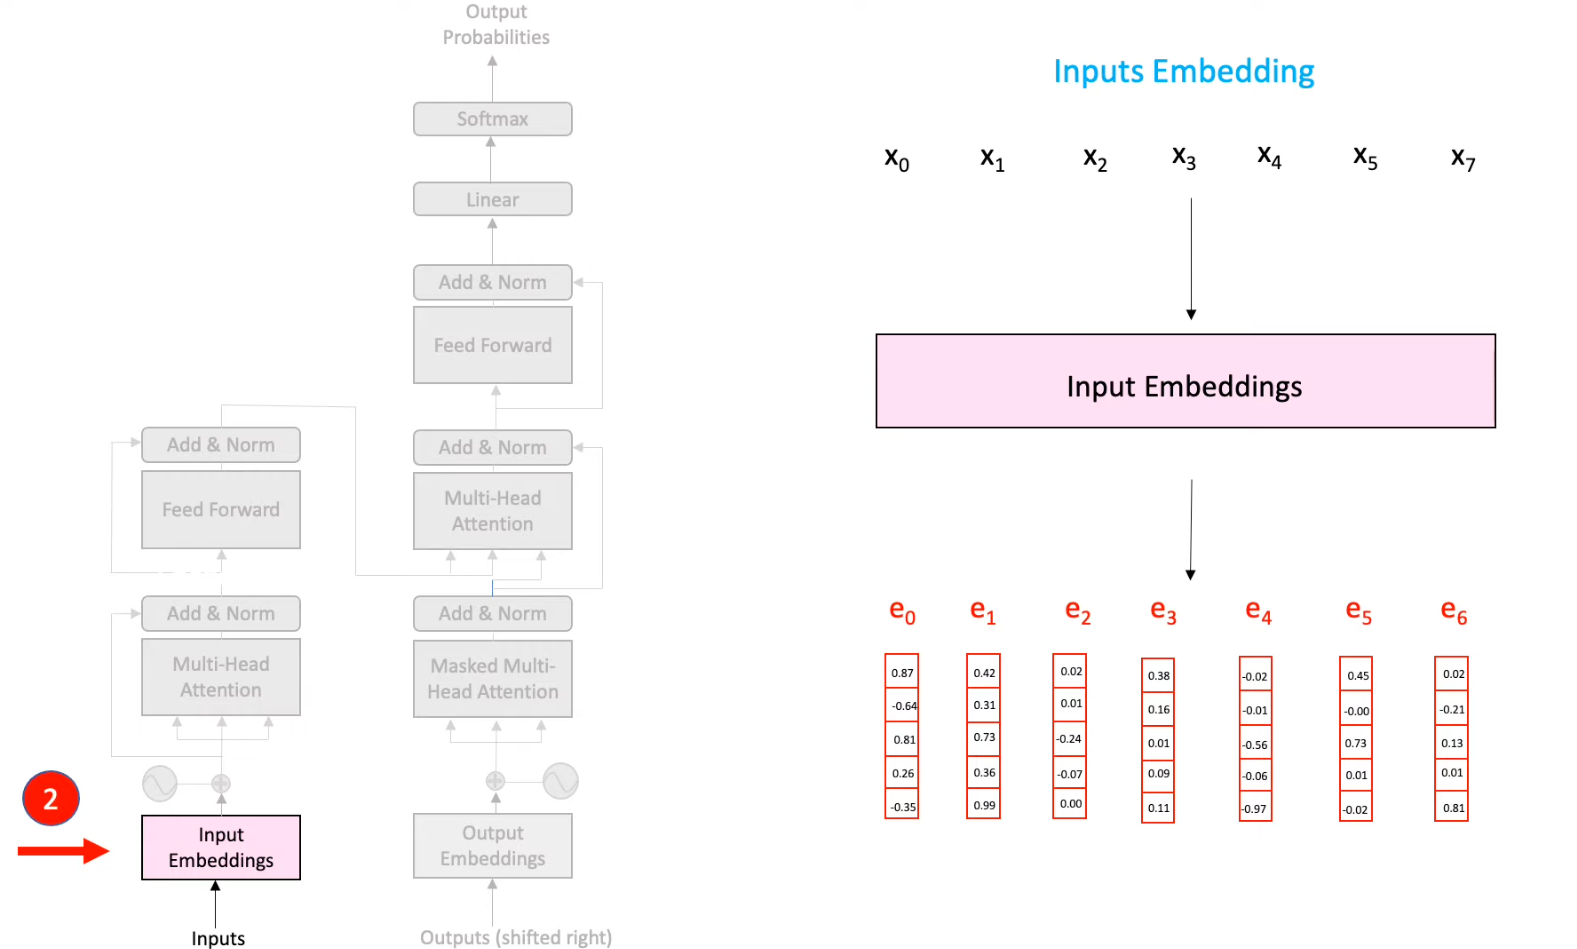




### 1.3 Positional Embedding

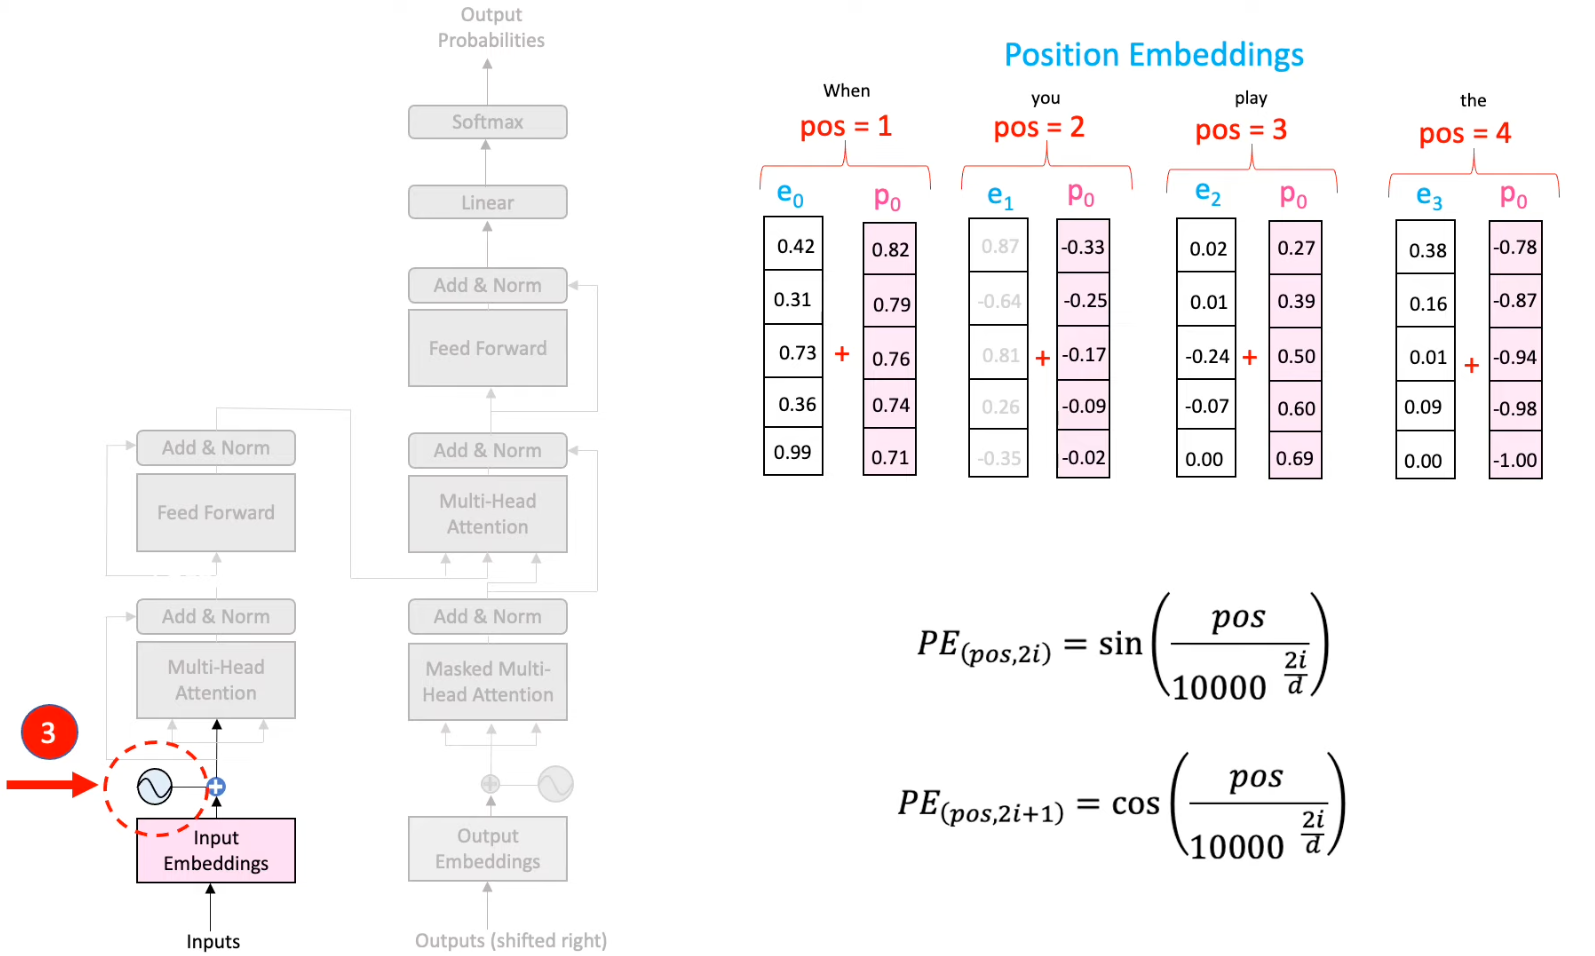

Embeddings on the input, however, doesn't have information of word orders. That's when Positional embeddings comes to the rescue.

Suppose we have following 2 sentences:

1. Even though she did not win the award, she was satisfied.
2. Even though she did win the award, she was not satisfied

If we look at the words, it is exactly the same however, only the location of the word `not` is different - therefore changes the meaning completely. Position embeddings brings the order to the word.

### 1.4 Download dataset

In [ ]:
# !wget https://gist.githubusercontent.com/amarsaikhanb/fdeaa5c5c33c985891c7175c204cd086/raw/d765dbf2c4f74863a1789e74ebf8780a9d081adc/src_train_mini.txt
# !wget https://gist.githubusercontent.com/amarsaikhanb/fdeaa5c5c33c985891c7175c204cd086/raw/d765dbf2c4f74863a1789e74ebf8780a9d081adc/tgt_train_mini.txt
!wget https://gist.githubusercontent.com/amarsaikhanb/bbb4c3efd0796d393781df93b402c206/raw/096503d9bf90999e42e1bac506bee8ec8e16e8b1/src_train_mini_2.txt
!wget https://gist.githubusercontent.com/amarsaikhanb/bbb4c3efd0796d393781df93b402c206/raw/096503d9bf90999e42e1bac506bee8ec8e16e8b1/tgt_train_mini_2.txt

--2024-06-16 14:54:12--  https://gist.githubusercontent.com/amarsaikhanb/bbb4c3efd0796d393781df93b402c206/raw/096503d9bf90999e42e1bac506bee8ec8e16e8b1/src_train_mini_2.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51853 (51K) [text/plain]
Saving to: ‘src_train_mini_2.txt’

src_train_mini_2.tx 100%[===================>]  50.64K  --.-KB/s    in 0.001s  

2024-06-16 14:54:12 (43.5 MB/s) - ‘src_train_mini_2.txt’ saved [51853/51853]

--2024-06-16 14:54:12--  https://gist.githubusercontent.com/amarsaikhanb/bbb4c3efd0796d393781df93b402c206/raw/096503d9bf90999e42e1bac506bee8ec8e16e8b1/tgt_train_mini_2.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubuser

In [ ]:
import torch
from itertools import chain
from collections import Counter, OrderedDict


class Mini_EN_MN_Dataset:
    def __init__(self,
                 max_len=20,
                 src_filepath='/content/src_train_mini.txt',
                 tgt_filepath=None,
                 vocab=(None, None),
                 is_src=True, is_tgt=True, is_train=True):

        self.max_len = max_len

        src, tgt = [], []

        orig_src, src, vocab = self.load_data(src_filepath, vocab=vocab[0], is_src=is_src, is_train=is_train)
        self.orig_src = orig_src
        self.src = src

        orig_tgt, tgt, vocab = self.load_data(tgt_filepath, vocab=vocab, is_src=is_tgt, is_train=is_train)
        self.orig_tgt = orig_tgt
        self.tgt = tgt
        self.vocab = vocab

    def __getitem__(self, index):
        data, targets = self.src[index], self.tgt[index]
        return data, targets

    def __len__(self):
        return len(self.src)

    def load_data(self, filepath, vocab=None, is_src=True, is_train=True):
        if filepath is None:
            # lines: empty list, seq: fake labels, vocab: vocab
            return [], torch.zeros((self.src.shape[0], self.src.shape[1]+1), dtype=self.src.dtype), vocab

        lines = []
        with open(filepath, 'r', encoding='UTF-8') as f:
            for line in f:
                lines.append(line.strip().split(' '))

        if is_train:
            vocab = self.init_vocab(lines, vocab)

        seqs = self.convert_sent2seq(lines, vocab=vocab, is_src=is_src)

        return lines, seqs, vocab

    def init_vocab(self, sents, vocab):

        vocab = OrderedDict({
            '[PAD]': 2,
            '[UNK]': 3,
            '[SOS]': 0,
            '[EOS]': 1,
        }) if vocab is None else vocab
        n_special_word = len(vocab)
        counter = Counter(list(chain.from_iterable(sents)))
        ordered_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
        for key, _ in ordered_dict.copy().items():
            if key in vocab.keys():
                del ordered_dict[key]
        vocab.update({k: idx + n_special_word for idx, k in enumerate(ordered_dict.keys())})
        return vocab

    def convert_sent2seq(self, sents, vocab=None, is_src=True):
        sent_seq = []
        for s in sents:
            s_pad = self.padding(s, max_len=self.max_len, is_src=is_src)
            s_seq = []
            for w in s_pad:
                w_mod = w if w in vocab else '[UNK]'
                s_seq.append(vocab[w_mod])
            sent_seq.append(torch.tensor(s_seq, dtype=torch.int64).unsqueeze(0))
        sent_seq = torch.vstack(sent_seq)

        return sent_seq

    def padding(self, tokens, max_len=20, is_src=True):
        w_sos = ['[SOS]']
        w_seq = [tokens[i] if i < len(tokens) else '[PAD]' for i in range(max_len + 1)]

        if is_src:
          w_seq = w_seq[:-1]
        else:
          #w_seq[len(tokens)-1 if len(tokens) <= max_len else max_len-1] = '[EOS]'
          w_seq = w_sos + w_seq[:-1]
          w_seq[len(tokens) + 1 if len(tokens) < max_len  else max_len] = '[EOS]'
        #print("w_seq", w_seq)
        return w_seq


In [ ]:
trn_dataset = Mini_EN_MN_Dataset(max_len=20, src_filepath='/content/src_train_mini_2.txt', tgt_filepath='/content/tgt_train_mini_2.txt', vocab=(None, None), is_src=True, is_tgt=False, is_train=True)
trn_dataset

In [ ]:
"Number of token:", len(trn_dataset.vocab)

('Number of token:', 1996)

In [ ]:
list(trn_dataset.vocab.items())[:20]

[('[PAD]', 2),
 ('[UNK]', 3),
 ('[SOS]', 0),
 ('[EOS]', 1),
 ('I', 4),
 ('is', 5),
 ('am', 6),
 ('a', 7),
 ('feeling', 8),
 ('to', 9),
 ('for', 10),
 ('the', 11),
 ('about', 12),
 ('That', 13),
 ('really', 14),
 ('Let', 15),
 ('it!', 16),
 ('She', 17),
 ('He', 18),
 ('your', 19)]

### 1.5 Implementation

In [ ]:
embedding = nn.Embedding(len(trn_dataset.vocab), model_dim) #1996, 512

In [ ]:
class Embedding_Layer(nn.Module):

    def __init__(self, num_token, dim_model, max_seq_len, d_prob):
        """Implementation of embedding and positional embeddings.

        Args:
            num_token (int): Number of token
            dim_model (_type_): Dimension of the model
            max_seq_len (_type_): Maximum sequence length
            d_prob (_type_): Dropout probability
        """
        super(Embedding_Layer, self).__init__()
        self.num_token = num_token # 1996
        self.dim_model = dim_model # 512
        self.max_seq_len = max_seq_len #20
        self.d_prob = d_prob
        self.emb = nn.Embedding(num_token, dim_model) # 1996, 512
        self.drop_out = nn.Dropout(d_prob) # Apply dropout with 10% probability to zero to prevent overfitting
        self.pos_enc = torch.zeros((self.max_seq_len, self.dim_model))
        for pos in range(self.max_seq_len):
            for idx in range(0, self.dim_model, 2):
                self.pos_enc[pos, idx] = torch.sin(torch.tensor(pos / (10000.0) ** (float(idx) / self.dim_model)))
                self.pos_enc[pos, idx + 1] = torch.cos(torch.tensor(pos / (10000.0) ** (float(idx) / self.dim_model)))

    def forward(self, x, pos=None):
        # To do: Implement forward pass
        pass

In [ ]:
### Test
# emb_test = Embedding_Layer(1996, 512, 20, 0.1)
# input_test = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
# emb_test(input_test)

## 2. Transformer Encoder

### 2.1 Scaled Dot-Product Attention

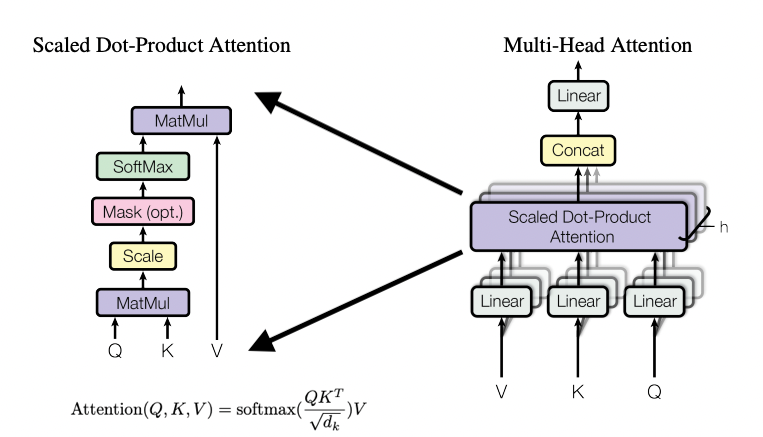

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, d_prob):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.softmax = nn.Softmax(dim=-1)
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x_q, x_k, x_v, pad_mask):
        # To do: Implement forward pass
        pass

### 2.2 Multi-Head Attention

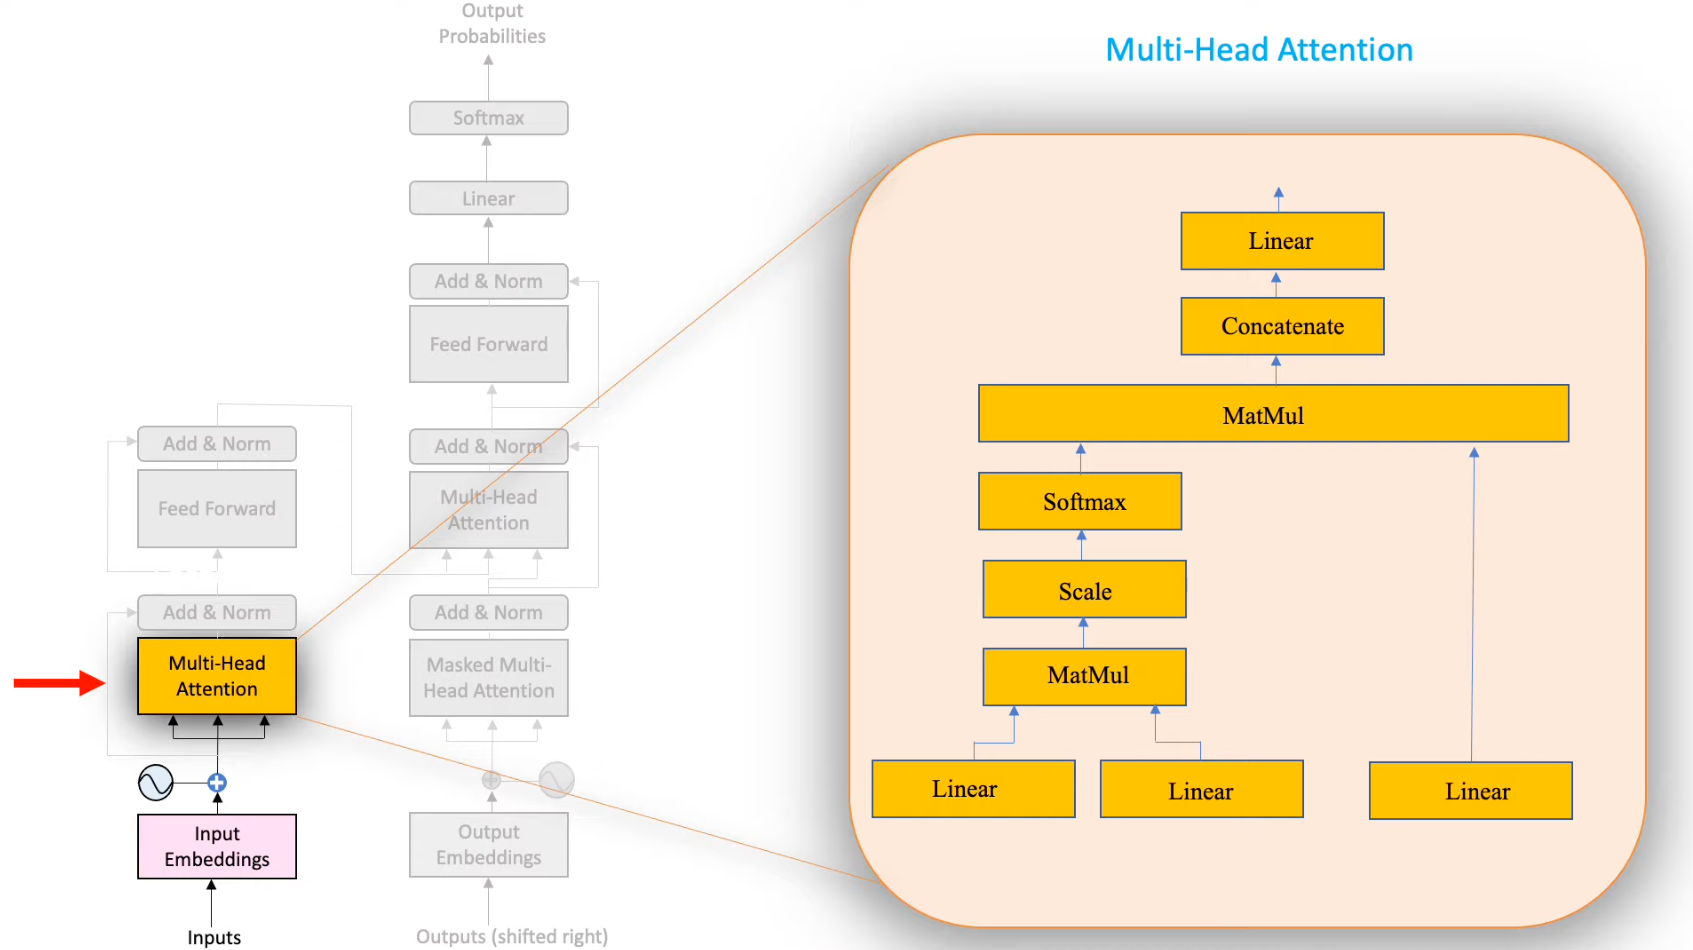

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, d_prob):
        super(MultiHeadAttention, self).__init__()

        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8

        self.w_q = nn.Linear(dim_model, n_head * d_k) # 512, 512
        self.w_k = nn.Linear(dim_model, n_head * d_k) # 512, 512
        self.w_v = nn.Linear(dim_model, n_head * d_v) # 512, 512
        self.w_o = nn.Linear(n_head * d_v, dim_model) # 512, 512

        self.scaled_dot_prod = ScaledDotProductAttention(d_k, d_prob)

    def forward(self, q, k, v, pad_mask):
        # To do : Implement forward pass
        pass

In [ ]:
MultiHeadAttention(model_dim, d_k, d_v, n_head, d_prob)

MultiHeadAttention(
  (w_q): Linear(in_features=512, out_features=512, bias=True)
  (w_k): Linear(in_features=512, out_features=512, bias=True)
  (w_v): Linear(in_features=512, out_features=512, bias=True)
  (w_o): Linear(in_features=512, out_features=512, bias=True)
  (scaled_dot_prod): ScaledDotProductAttention(
    (softmax): Softmax(dim=-1)
    (drop_out): Dropout(p=0.1, inplace=False)
  )
)

### 2.3 Feed Forward

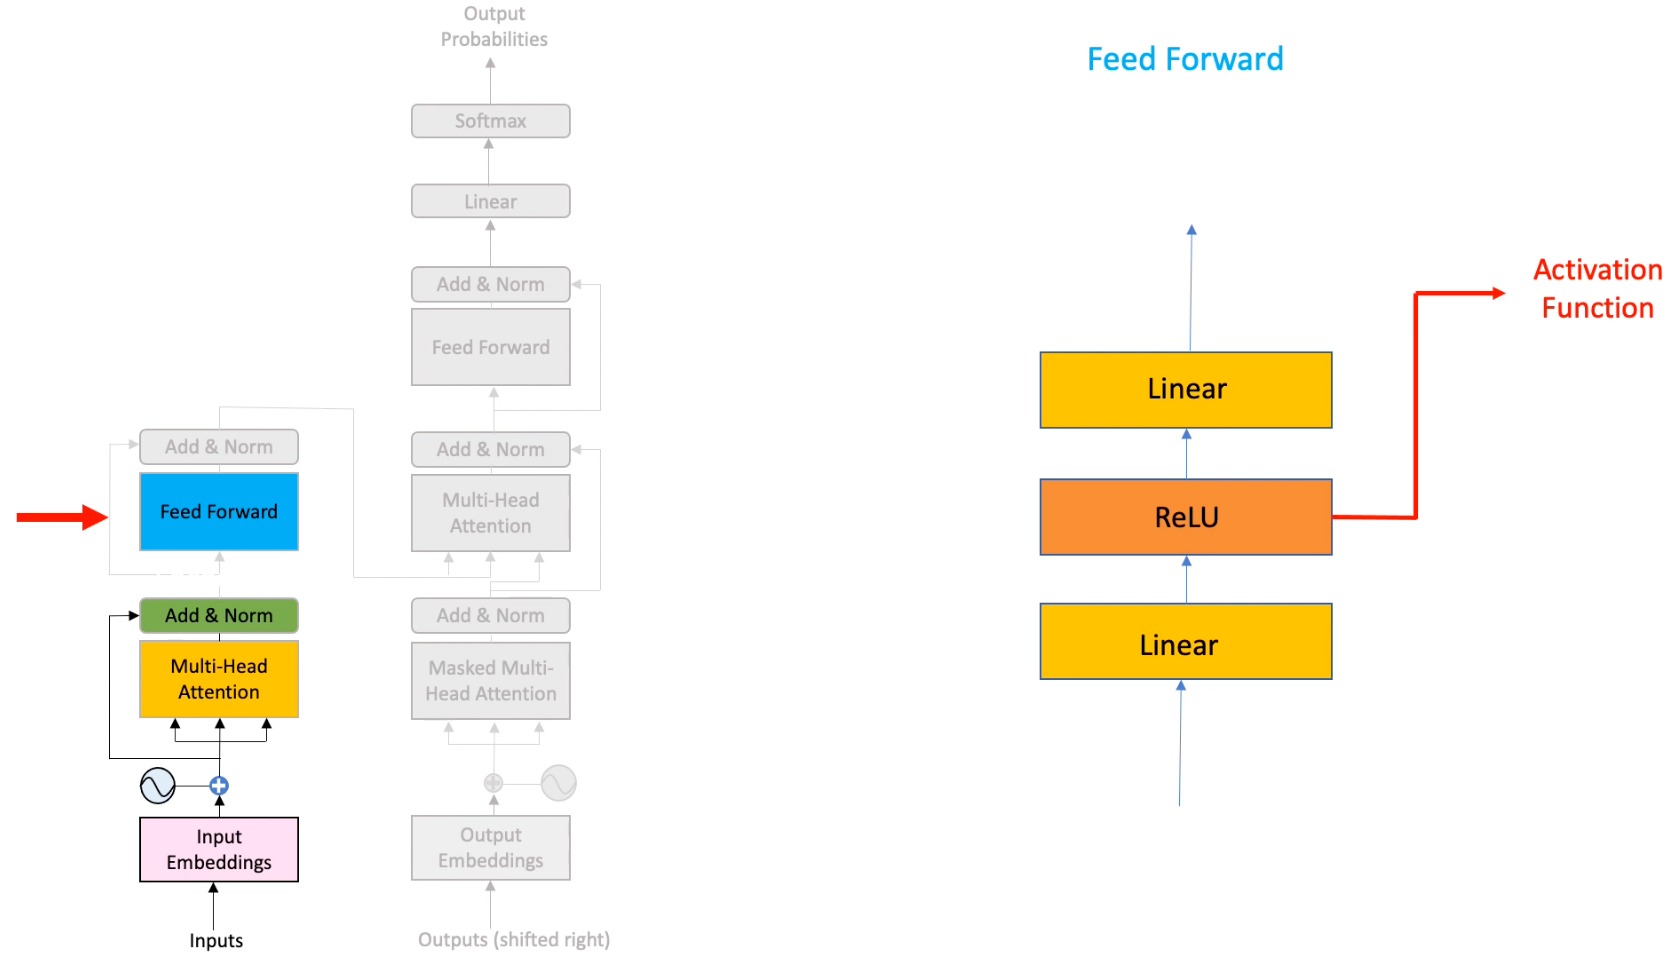

In [ ]:
class FFNN(nn.Module):
    def __init__(self, dim_model, dim_hidden, d_prob):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(dim_model, dim_hidden) # 512, 2048
        self.fc2 = nn.Linear(dim_hidden, dim_model) # 2048, 512

        self.relu = nn.ReLU()
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x):
        pass
        # To do : Implement forward pass
FFNN(model_dim, hidden_size, d_prob)

FFNN(
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (relu): ReLU()
  (drop_out): Dropout(p=0.1, inplace=False)
)

### 2.4 Encoder layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob):
        super(EncoderLayer, self).__init__()
        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8
        self.dim_hidden = dim_hidden # 2048
        self.d_prob = d_prob

        self.multi_head_attn = MultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.ffnn = FFNN(dim_model, dim_hidden, d_prob)

        self.layer_norm1 = nn.LayerNorm(dim_model) # 512
        self.layer_norm2 = nn.LayerNorm(dim_model) # 512

        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x, src_pad_mask):
        # To do : Implement forward pass
        pass
EncoderLayer(model_dim, d_k, d_v, n_head, hidden_size, d_prob)

EncoderLayer(
  (multi_head_attn): MultiHeadAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
    (scaled_dot_prod): ScaledDotProductAttention(
      (softmax): Softmax(dim=-1)
      (drop_out): Dropout(p=0.1, inplace=False)
    )
  )
  (ffnn): FFNN(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (relu): ReLU()
    (drop_out): Dropout(p=0.1, inplace=False)
  )
  (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (drop_out): Dropout(p=0.1, inplace=False)
)

### 2.5 Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_enc_layer):
        super(Encoder, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8
        self.dim_hidden = dim_hidden # 2048
        self.d_prob = d_prob
        self.n_enc_layer = n_enc_layer # 6

        self.enc_layers = nn.ModuleList([EncoderLayer(dim_model, d_k, d_v, n_head, dim_hidden, d_prob) for _ in range(n_enc_layer)])

    def forward(self, x, src_pad_mask):
        for layer in self.enc_layers:
            x = layer(x, src_pad_mask)
        return x
Encoder(model_dim, d_k, d_v, n_head, hidden_size, d_prob, num_enc_layers)

Encoder(
  (enc_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (multi_head_attn): MultiHeadAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (w_o): Linear(in_features=512, out_features=512, bias=True)
        (scaled_dot_prod): ScaledDotProductAttention(
          (softmax): Softmax(dim=-1)
          (drop_out): Dropout(p=0.1, inplace=False)
        )
      )
      (ffnn): FFNN(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
        (drop_out): Dropout(p=0.1, inplace=False)
      )
      (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_out): Dropout(p=0.1, inplace=False)
    )
  )
)

## 3. Transformer Decoder

Decoder is basically the same as Encoder implementation. However, there are only a few pieces that are different as shown below:

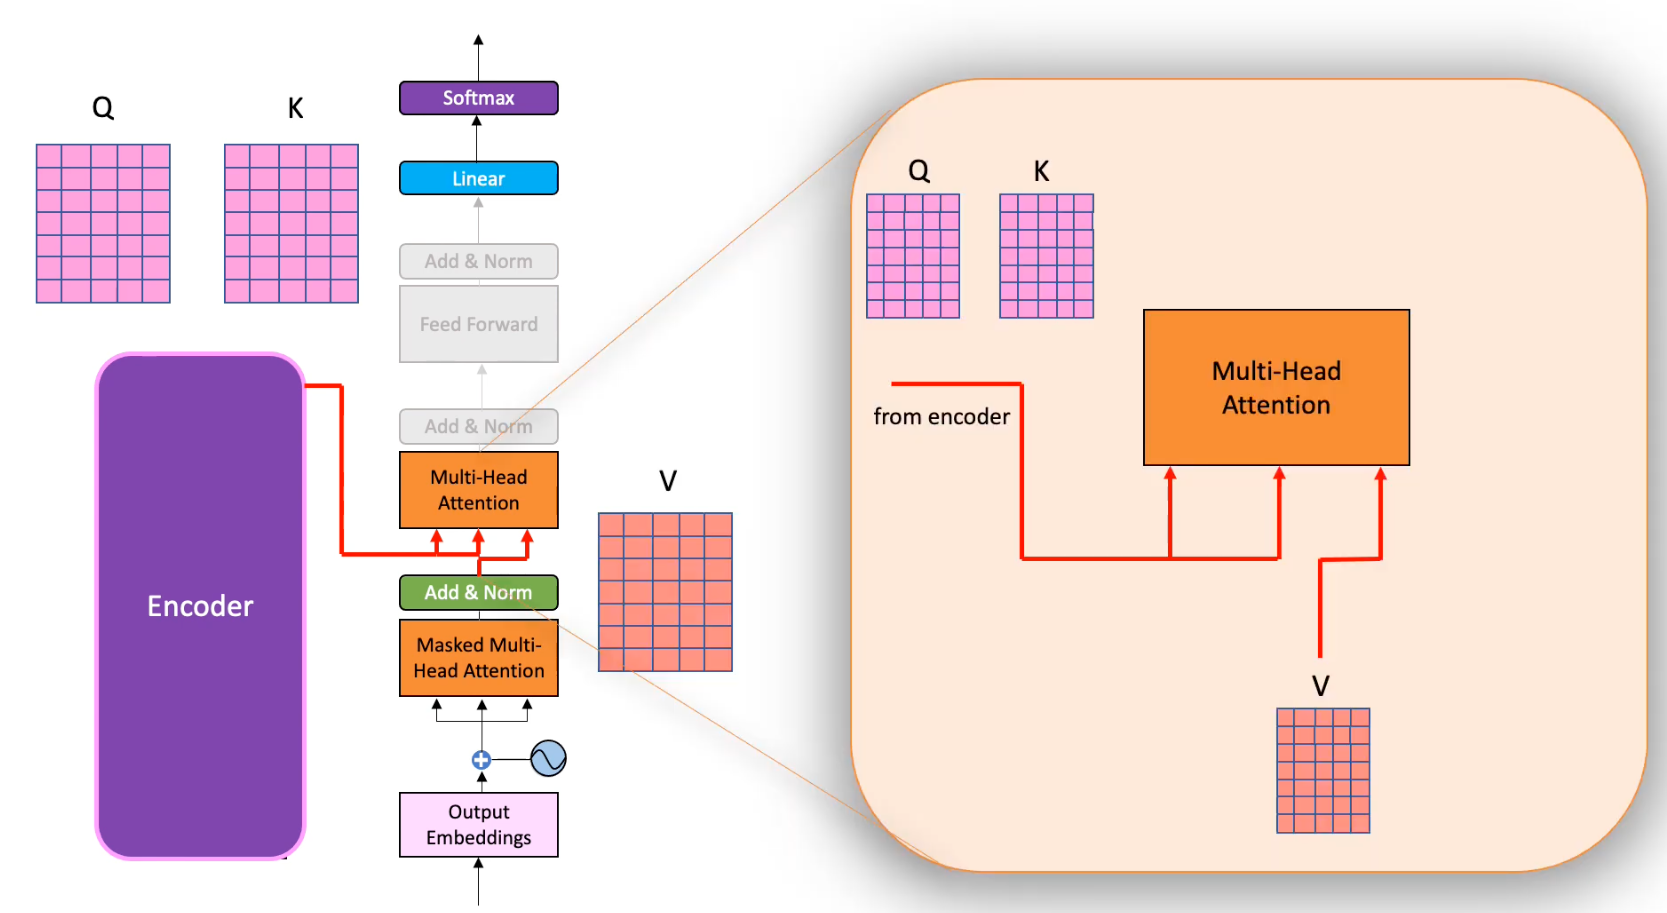

### Why masking?



In short, to avoid information leakage - as target needs to be hidden until it is needed.

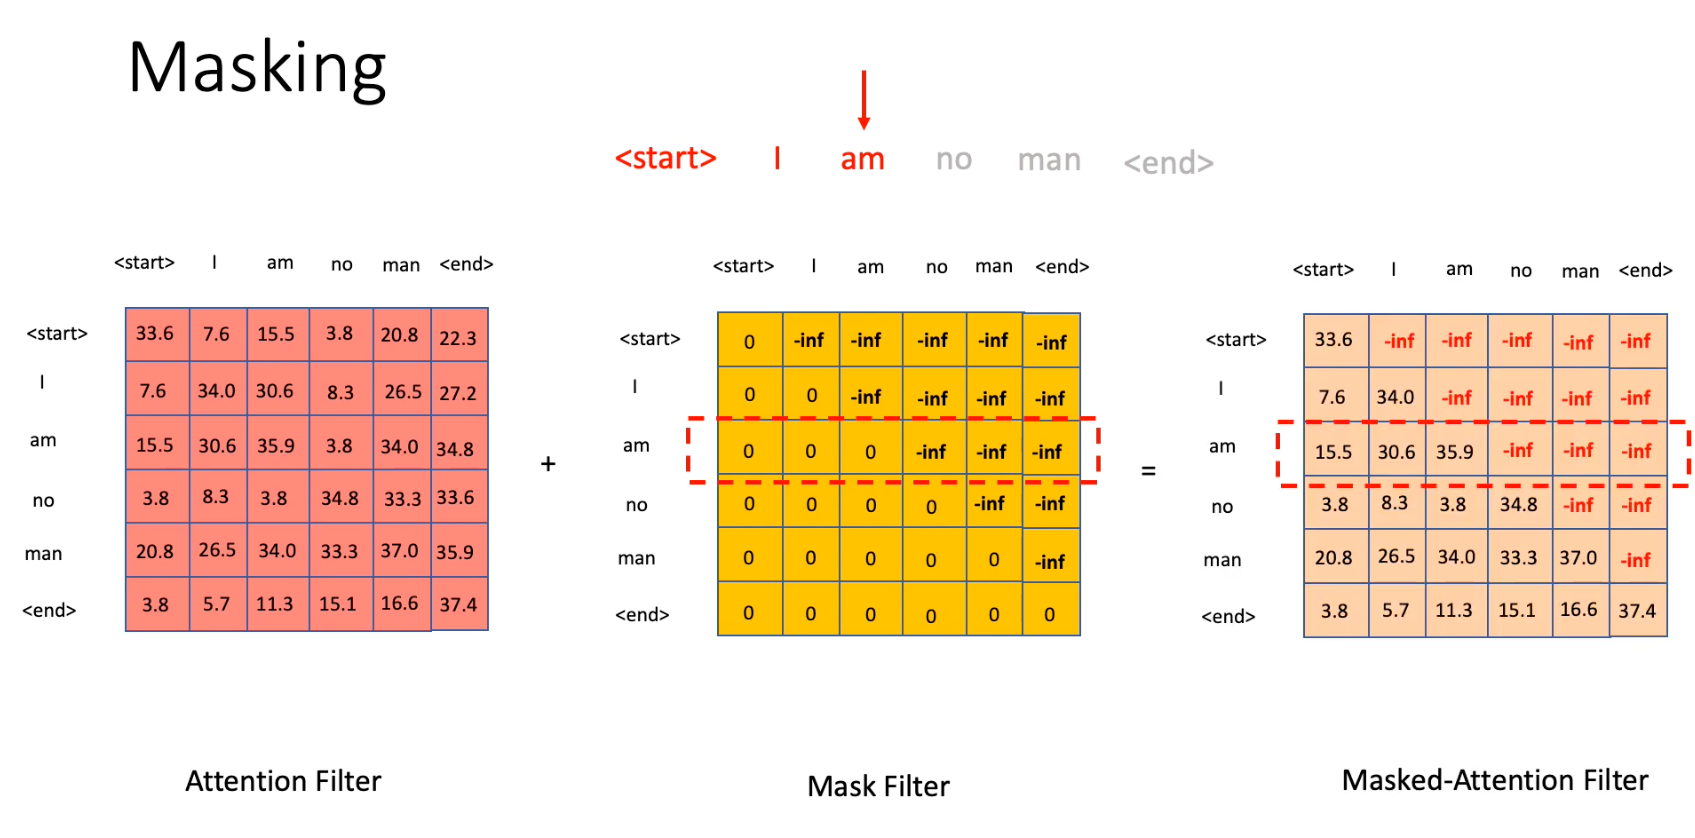

In [ ]:
a = torch.ones(5, 5)
a

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [ ]:
torch.tril(a)

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

### 3.1 Scaled Dot-Product Attention (Masked)

In [ ]:
class MaskedScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, d_prob):
        super(MaskedScaledDotProductAttention, self).__init__()
        self.d_k = d_k # 64
        self.softmax = nn.Softmax(dim=-1)
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x_q, x_k, x_v, pad_mask):
        # To Do: Implement forward pass
        pass
MaskedScaledDotProductAttention(d_k, d_prob)

MaskedScaledDotProductAttention(
  (softmax): Softmax(dim=-1)
  (drop_out): Dropout(p=0.1, inplace=False)
)

### 3.2 Masked Multi-Head Attention

In [ ]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, d_prob):
        super(MaskedMultiHeadAttention, self).__init__()
        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8

        self.w_q = nn.Linear(dim_model, n_head * d_k) # 512, 512
        self.w_k = nn.Linear(dim_model, n_head * d_k) # 512, 512
        self.w_v = nn.Linear(dim_model, n_head * d_v) # 512, 512
        self.w_o = nn.Linear(n_head * d_v, dim_model) # 512, 512

        self.masked_scaled_dot_prod = MaskedScaledDotProductAttention(d_k, d_prob)

    def forward(self, q, k, v, pad_mask):
        # TO DO: Implement forward pass
        pass
MaskedMultiHeadAttention(model_dim, d_k, d_v, n_head, d_prob)

MaskedMultiHeadAttention(
  (w_q): Linear(in_features=512, out_features=512, bias=True)
  (w_k): Linear(in_features=512, out_features=512, bias=True)
  (w_v): Linear(in_features=512, out_features=512, bias=True)
  (w_o): Linear(in_features=512, out_features=512, bias=True)
  (masked_scaled_dot_prod): MaskedScaledDotProductAttention(
    (softmax): Softmax(dim=-1)
    (drop_out): Dropout(p=0.1, inplace=False)
  )
)

### 3.3 Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob):
        super(DecoderLayer, self).__init__()
        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8
        self.dim_hidden = dim_hidden # 2048
        self.d_prob = d_prob

        self.masked_multi_head_attention = MaskedMultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.multi_head_attention = MultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.ffnn = FFNN(dim_model, dim_hidden, d_prob)

        self.layer_norm1 = nn.LayerNorm(dim_model) # 512
        self.layer_norm2 = nn.LayerNorm(dim_model) # 512
        self.layer_norm3 = nn.LayerNorm(dim_model) # 512

        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x, enc_output, tgt_pad_mask, src_tgt_pad_mask):
        # To Do: Implement forward pass
        pass
DecoderLayer(model_dim, d_k, d_v, n_head, hidden_size, d_prob)

DecoderLayer(
  (masked_multi_head_attention): MaskedMultiHeadAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
    (masked_scaled_dot_prod): MaskedScaledDotProductAttention(
      (softmax): Softmax(dim=-1)
      (drop_out): Dropout(p=0.1, inplace=False)
    )
  )
  (multi_head_attention): MultiHeadAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
    (scaled_dot_prod): ScaledDotProductAttention(
      (softmax): Softmax(dim=-1)
      (drop_out): Dropout(p=0.1, inplace=False)
    )
  )
  (ffnn): FFNN(
    (fc1): Linear(in_features=512, out_features=2048, bias

### 3.4 Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_dec_layer):
        super(Decoder, self).__init__()
        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v # 64
        self.n_head = n_head # 8
        self.dim_hidden = dim_hidden # 2048
        self.d_prob = d_prob
        self.n_dec_layer = n_dec_layer # 6

        self.dec_layers = nn.ModuleList([DecoderLayer(dim_model, d_k, d_v, n_head, dim_hidden, d_prob) for _ in range(n_dec_layer)])

    def forward(self, x, enc_output, tgt_pad_mask=None, src_tgt_pad_mask=None):
        for layer in self.dec_layers:
            x = layer(x, enc_output, tgt_pad_mask, src_tgt_pad_mask)
        return x
Decoder(model_dim, d_k, d_v, n_head, hidden_size, d_prob, num_dec_layers)

Decoder(
  (dec_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (masked_multi_head_attention): MaskedMultiHeadAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (w_o): Linear(in_features=512, out_features=512, bias=True)
        (masked_scaled_dot_prod): MaskedScaledDotProductAttention(
          (softmax): Softmax(dim=-1)
          (drop_out): Dropout(p=0.1, inplace=False)
        )
      )
      (multi_head_attention): MultiHeadAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (w_o): Linear(in_features=512, out_features=512, bias=True)
        (scaled_dot_prod): ScaledDotProductAttention(
          (softmax): Softmax(dim=-1)
          (d

## 4. Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_token, max_seq_len, dim_model, d_k=64, d_v=64, n_head=8, dim_hidden=2048, d_prob=0.1, n_enc_layer=6, n_dec_layer=6):
        super(Transformer, self).__init__()

        self.num_token = num_token # 1996
        self.max_seq_len = max_seq_len # 20
        self.embed = Embedding_Layer(num_token=num_token, dim_model=dim_model, max_seq_len=max_seq_len, d_prob=d_prob)
        self.encoder = Encoder(dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_enc_layer)
        self.decoder = Decoder(dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_dec_layer)
        self.linear = nn.Linear(dim_model, num_token)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src, tgt):
        positional_encoded_src = self.embed(src)
        src_pad_mask = self.make_mask(src)
        enc_output = self.encoder(positional_encoded_src, src_pad_mask.bool())

        positional_encoded_tgt = self.embed(tgt)
        tgt_pad_mask = self.make_mask(tgt)
        tgt_src_pad_mask = torch.bmm(tgt_pad_mask, src_pad_mask.transpose(-1, -2))
        dec_output = self.decoder(positional_encoded_tgt, enc_output, tgt_pad_mask.bool(), tgt_src_pad_mask.bool())
        outputs = self.softmax(self.linear(dec_output))

        return outputs

    def make_mask(self, x):
        pad_mask = torch.where(x==2, 0., 1.)
        pad_mask = pad_mask.unsqueeze(-1)
        pad_mask = torch.bmm(pad_mask, pad_mask.transpose(-1, -2))
        return pad_mask
Transformer(len(trn_dataset.vocab), max_len, model_dim, d_k, d_v, n_head, hidden_size, d_prob, num_enc_layers, num_dec_layers)

Transformer(
  (embed): Embedding_Layer(
    (emb): Embedding(1996, 512)
    (drop_out): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multi_head_attn): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_o): Linear(in_features=512, out_features=512, bias=True)
          (scaled_dot_prod): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
            (drop_out): Dropout(p=0.1, inplace=False)
          )
        )
        (ffnn): FFNN(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (drop_out): Dropout(p=0.1, inplace=False)
        )
        (layer_norm1): LayerNorm((512,), eps=

#### BLEU score
BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text.

In [ ]:
import math
import collections

def bleu_score(pred, tgt, k=4):
    # Lengths of the predicted and target sentences
    len_pred = len(pred)
    len_tgt = len(tgt)

    # Brevity penalty calculation
    if len_pred >= len_tgt:
        brevity_penalty = 1
    else:
        brevity_penalty = math.exp(1 - len_tgt / len_pred)

    # Initialize the BLEU score with the brevity penalty
    bleu_score = brevity_penalty

    # Loop over n-gram lengths from 1 to k
    for n in range(1, k + 1):
        num_matches = 0  # Count of matching n-grams
        target_ngrams = collections.defaultdict(int)  # Dictionary to store n-gram counts from target sentence

        # Extract n-grams from the target sentence
        for i in range(len_tgt - n + 1):
            ngram = ' '.join(tgt[i: i + n])
            target_ngrams[ngram] += 1

        # Count matching n-grams in the predicted sentence
        for i in range(len_pred - n + 1):
            ngram = ' '.join(pred[i: i + n])
            if target_ngrams[ngram] > 0:
                num_matches += 1
                target_ngrams[ngram] -= 1

        # Precision calculation for the current n-gram length
        if len_pred >= n:
            precision = num_matches / (len_pred - n + 1)
        else:
            precision = 0

        # Update the BLEU score with the current precision raised to the power of 0.5^n
        bleu_score *= math.pow(precision, math.pow(0.5, n))

    return bleu_score



### Training Transformer

In [ ]:
def train(dataloader, epochs, model, criterion, vocab, i2w):
	model.train()
	model.zero_grad()
	optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2), eps=eps)
	correct = 0

	cnt = 0
	total_score = 0.
	global_step = 0
	tr_loss = 0.
	for epoch in range(epochs):

		for idx, (src, tgt) in enumerate(dataloader):
			src, tgt = src.to(device), tgt.to(device)
			optimizer.zero_grad()

			outputs = model(src, tgt[:, :-1])
			tgt = tgt[:, 1:]

			tgt = torch.flatten(tgt)
			outputs = outputs.reshape(len(tgt), -1)
			loss = criterion(outputs, tgt)
			tr_loss += loss.item()

			loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
			optimizer.step()
			global_step += 1

			pred = outputs.argmax(dim=1, keepdim=True)
			pred_acc = pred[tgt != 2]
			tgt_acc = tgt[tgt != 2]

			correct += pred_acc.eq(tgt_acc.view_as(pred_acc)).sum().item()

			cnt += tgt_acc.shape[0]
			score = 0.

			with torch.no_grad():
				pred = pred.reshape(batch_size, max_len, -1).detach().cpu().tolist()
				tgt = tgt.reshape(batch_size, max_len).detach().cpu().tolist()
				for p, t in zip(pred, tgt):
					eos_idx = t.index(vocab['[PAD]']) if vocab['[PAD]'] in t else len(t)
					p_seq = [i2w[i[0]] for i in p][:eos_idx]
					t_seq = [i2w[i] for i in t][:eos_idx]
					k = 4 if len(t_seq) > 4 else len(t_seq)
					s = bleu_score(p_seq, t_seq, k=k)
					score += s
					total_score += s

			score /= batch_size

			print("\r[epoch {:3d}/{:3d}] [batch {:4d}/{:4d}] loss: {:.6f} acc: {:.4f} BLEU: {:.4f})".format(
				epoch, n_epochs, idx + 1, len(dataloader), loss, correct / cnt, score), end=' ')

	tr_loss /= cnt
	tr_acc = correct / cnt
	tr_score = total_score / len(dataloader.dataset) / epochs

	return tr_loss, tr_acc, tr_score

def eval(dataloader, model, lengths=None):
    # Implement this
    pass

In [ ]:
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
set_random_seed(42)
vocab = trn_dataset.vocab
i2w = {v: k for k, v in vocab.items()}
trn_dataloader = DataLoader(trn_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
n_token = len(trn_dataset.vocab)
model = Transformer(num_token=n_token, max_seq_len=max_len, dim_model=model_dim, d_k=d_k, d_v=d_v, n_head=n_head, dim_hidden=hidden_size, d_prob=d_prob, n_enc_layer=num_enc_layers, n_dec_layer=num_dec_layers)
model = model.to(device)
criterion = nn.NLLLoss(ignore_index=vocab['[PAD]'])
#n_epochs
tr_loss, tr_acc, tr_score = train(trn_dataloader, n_epochs, model, criterion, vocab, i2w)
print("tr: ({:.4f}, {:5.2f}, {:5.2f}) | ".format(tr_loss, tr_acc * 100, tr_score * 100), end='')


[epoch  99/100] [batch   11/  11] loss: 0.033021 acc: 0.9087 BLEU: 0.9975) tr: (0.0007, 90.87, 82.44) | 

In [ ]:
trn_dataset.src[0]

tensor([359, 230, 360,   5, 231, 361,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2])

In [ ]:
len(trn_dataset.vocab)

1996

In [ ]:
sentence_list = [
    "Thank you for your support.",
    "I am feeling so happy about it!",
    "Congrats on your success!",
    "They went shopping.",
    "Let is go for a swim at the beach.",
    "She is really creative with her presentations."
]
sentence_list = [sentence.strip().split(' ') for sentence in sentence_list]
trn_dataset.convert_sent2seq(sents=sentence_list, vocab=trn_dataset.vocab, is_src=True)

tensor([[ 46,  35,  10,  19, 214,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2],
        [  4,   6,   8,  41,  86,  12,  16,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2],
        [100,  33,  19, 232,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2],
        [ 44, 195, 909,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2],
        [ 15,   5,  21,  10,   7, 196,  36,  11, 211,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2],
        [ 17,   5,  14,  73,  20,  38, 329,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2]])

In [ ]:
def translate(sentence_list, model, vocab, i2w):
  for sentence in sentence_list:
    with torch.no_grad():
      src = torch.LongTensor(trn_dataset.convert_sent2seq(sents=[sentence], vocab=vocab)).to(device)
      src_pad_mask = model.make_mask(src).to(device)
      print("EN:", sentence)
      outputs = model(src, src)
      pred = outputs.argmax(dim=2, keepdim=True)
      pred = pred.reshape(1, max_len, -1).detach().cpu().tolist()
      for p in pred:
        eos_idx = p.index(vocab['[PAD]']) if vocab['[PAD]'] in p else len(p)
        p_seq = [i2w[i[0]] for i in p][:eos_idx]
        print("MN: ", p_seq)
    print("-----------------")
translate(sentence_list, model, vocab, i2w)


EN: ['Thank', 'you', 'for', 'your', 'support.']
MN:  ['баярлалаа.', 'баярлалаа.', 'баярлалаа.', 'баярлалаа.', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]']
-----------------
EN: ['I', 'am', 'feeling', 'so', 'happy', 'about', 'it!']
MN:  ['[EOS]', 'байна.', '[EOS]', '[EOS]', '[EOS]', 'байна.', 'байна.', '[EOS]', '[EOS]', '[EOS]', '[EOS]', 'байна.', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]']
-----------------
EN: ['Congrats', 'on', 'your', 'success!']
MN:  ['[EOS]', 'баяр', 'баяр', 'баяр', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]']
-----------------
EN: ['They', 'went', 'shopping.']
MN:  ['[EOS]', 'үүнд', '[EOS]', '[EOS]', 'баярлалаа.', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[E

In [ ]:
model

Transformer(
  (embed): Embedding_Layer(
    (emb): Embedding(1996, 512)
    (drop_out): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multi_head_attn): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_o): Linear(in_features=512, out_features=512, bias=True)
          (scaled_dot_prod): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
            (drop_out): Dropout(p=0.1, inplace=False)
          )
        )
        (ffnn): FFNN(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (drop_out): Dropout(p=0.1, inplace=False)
        )
        (layer_norm1): LayerNorm((512,), eps=

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
outputs = model(src, src)

# Create a visualization of the model graph
dot = make_dot(outputs, params=dict(model.named_parameters()))

In [ ]:
model(src, src)

tensor([[[-9.2355e+00, -1.5662e+00, -9.2355e+00,  ..., -8.3671e+00,
          -1.1459e+01, -8.8940e+00],
         [-1.0242e+01, -3.5369e-01, -1.0242e+01,  ..., -8.8808e+00,
          -1.2001e+01, -9.0650e+00],
         [-1.2289e+01, -6.7839e-02, -1.2289e+01,  ..., -1.1467e+01,
          -1.3227e+01, -1.0009e+01],
         ...,
         [-1.3723e+01, -3.9176e-02, -1.3723e+01,  ..., -1.0199e+01,
          -1.5693e+01, -1.4134e+01],
         [-1.4255e+01, -2.1281e-02, -1.4255e+01,  ..., -1.0391e+01,
          -1.6172e+01, -1.4740e+01],
         [-1.4300e+01, -1.5847e-02, -1.4300e+01,  ..., -1.0371e+01,
          -1.6089e+01, -1.4666e+01]]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
dot.render("model_graph")

'model_graph.pdf'